In [1]:
# === Cell 1: Title & Setup ===
# AI & ML Internship - Task 1
# Data Cleaning & Preprocessing (Google Colab-ready)
# Dataset: seaborn's 'titanic' sample (no external auth required)

# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

print("Setup complete. Libraries imported.")


Setup complete. Libraries imported.


In [2]:
# === Cell 2: Load dataset and initial exploration ===
df = sns.load_dataset('titanic')  # convenient Titanic-like dataset
print("Dataset loaded. Shape:", df.shape)
display(df.head(8))
print("\n--- Info ---")
display(df.info())
print("\n--- Missing values (per column) ---")
display(df.isnull().sum().sort_values(ascending=False))
print("\n--- Basic statistics (numerical) ---")
display(df.describe().T)
print("\n--- Basic statistics (object / category) ---")
display(df.describe(include=['object', 'category']).T)


Dataset loaded. Shape: (891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
7,0,3,male,2.0,3,1,21.0750,S,Third,child,False,NaN,Southampton,no,False



--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


None


--- Missing values (per column) ---


,0
deck,688
age,177
embarked,2
embark_town,2
sex,0
pclass,0
survived,0
fare,0
parch,0
sibsp,0



--- Basic statistics (numerical) ---


,count,mean,std,min,25%,50%,75%,max
survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
sibsp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292



--- Basic statistics (object / category) ---


,count,unique,top,freq
sex,891,2,male,577
embarked,889,3,S,644
class,891,3,Third,491
who,891,3,man,537
deck,203,7,C,59
embark_town,889,3,Southampton,644
alive,891,2,no,549


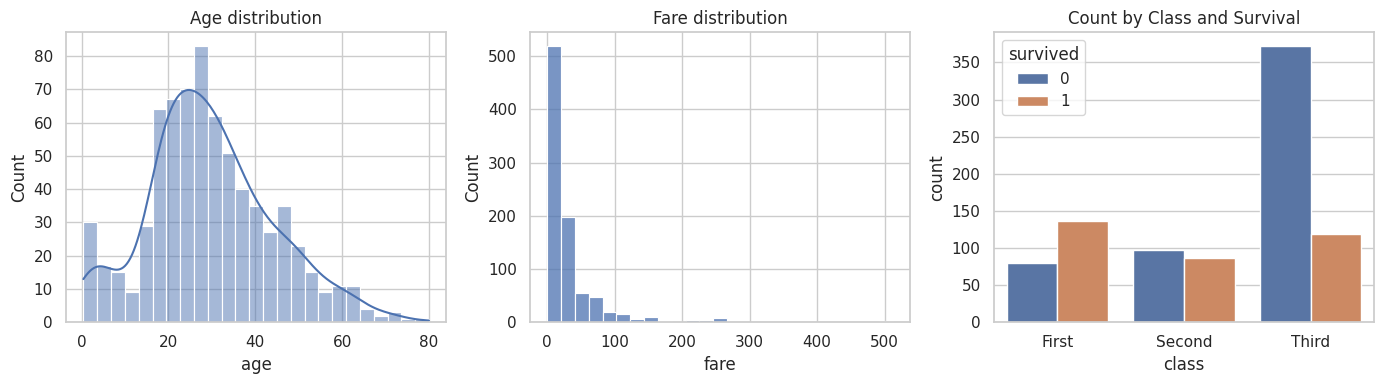

In [3]:
# === Cell 3: Quick EDA Visuals ===
# Visual: distribution of age, fare, and count by class / survived
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
sns.histplot(data=df, x='age', bins=25, kde=True)
plt.title('Age distribution')

plt.subplot(1,3,2)
sns.histplot(data=df, x='fare', bins=25)
plt.title('Fare distribution')

plt.subplot(1,3,3)
sns.countplot(data=df, x='class', hue='survived')
plt.title('Count by Class and Survival')

plt.tight_layout()
plt.show()


In [4]:
# === Cell 4: Missing value analysis & types ===
missing = df.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
print("Columns with missing values:\n", missing)
print("\nPercentage missing:")
display((df.isnull().mean().round(3) * 100).sort_values(ascending=False).head(10))


Columns with missing values:
 deck           688
age            177
embarked         2
embark_town      2
dtype: int64

Percentage missing:


,0
deck,77.2
age,19.9
embarked,0.2
embark_town,0.2
sex,0.0
pclass,0.0
survived,0.0
fare,0.0
parch,0.0
sibsp,0.0


In [5]:
# === Cell 5: Strategy plan (printed) ===
plan = """
Planned preprocessing steps:
1) Handle missing values:
   - age (numerical): median imputation
   - embarked (categorical): mode
   - deck (categorical, many missing): treat as 'Missing' category
2) Encode categorical variables:
   - one-hot: embarked, class, who, deck, adult_male? maybe drop if redundant
   - label-encode 'sex' or one-hot (I'll one-hot to be safe)
3) Scale numerical features: age, fare
4) Detect & handle outliers: IQR for 'fare' and 'age' (and optionally z-score)
5) Save cleaned dataset to CSV
"""
print(plan)



Planned preprocessing steps:
1) Handle missing values:
   - age (numerical): median imputation
   - embarked (categorical): mode
   - deck (categorical, many missing): treat as 'Missing' category
2) Encode categorical variables:
   - one-hot: embarked, class, who, deck, adult_male? maybe drop if redundant
   - label-encode 'sex' or one-hot (I'll one-hot to be safe)
3) Scale numerical features: age, fare
4) Detect & handle outliers: IQR for 'fare' and 'age' (and optionally z-score)
5) Save cleaned dataset to CSV



In [6]:
# === Cell 6: Copy dataset and minimal column selection ===
data = df.copy()
# For clarity, choose a subset of useful columns (typical for Titanic tasks)
cols = ['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class', 'who', 'adult_male', 'deck']
data = data[cols]
print("Working columns:", data.columns.tolist())
display(data.head())


Working columns: ['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class', 'who', 'adult_male', 'deck']


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN


In [7]:
# === Cell 7: Handle missing values (step-by-step) ===
# 1) 'deck' - many missing -> replace NaN with 'Missing'
data['deck'] = data['deck'].astype(object).fillna('Missing')

# 2) 'embarked' - categorical small missing -> fill with mode
emb_mode = data['embarked'].mode()[0]
data['embarked'] = data['embarked'].fillna(emb_mode)

# 3) 'age' - numerical missing -> fill with median (group-wise median by 'who' could be chosen too)
age_median = data['age'].median()
data['age'] = data['age'].fillna(age_median)

# 4) any other missing? print summary
print("Missing values after imputation:")
display(data.isnull().sum())


Missing values after imputation:


,0
survived,0
pclass,0
sex,0
age,0
sibsp,0
parch,0
fare,0
embarked,0
class,0
who,0


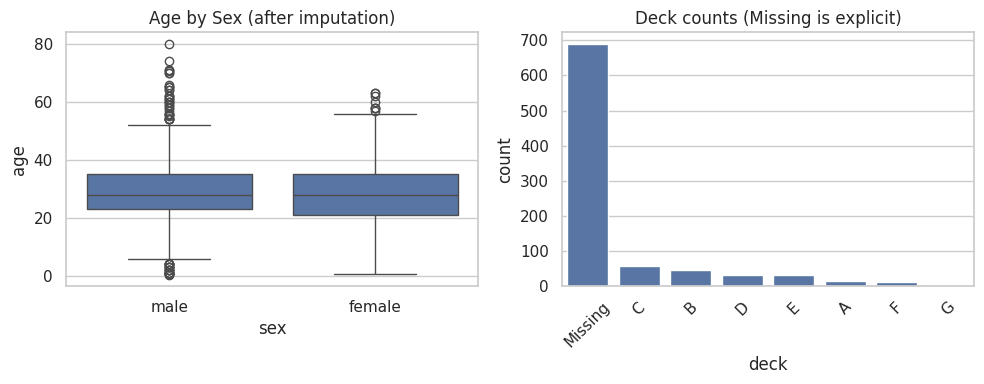

In [8]:
# === Cell 8: Validate imputation visually ===
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.boxplot(x='sex', y='age', data=data)
plt.title('Age by Sex (after imputation)')

plt.subplot(1,2,2)
sns.countplot(data=data, x='deck', order=data['deck'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Deck counts (Missing is explicit)')
plt.tight_layout()
plt.show()


In [9]:
# === Cell 9: Encoding categorical variables ===
# We'll do:
# - One-hot encoding for nominal vars: embarked, deck, who, class
# - Drop original columns where replaced by dummies
# - Leave 'sex' as one-hot as well
# - Keep pclass numeric (it's ordered but represented as 1,2,3), but also 'class' exists (string)
categorical_cols = ['sex','embarked','deck','who','class']
numeric_cols = ['age','sibsp','parch','fare','pclass']
target = 'survived'

# Use pandas get_dummies for human-style code (common in notebooks)
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=False, prefix_sep='__')
print("Encoded shape:", data_encoded.shape)
display(data_encoded.head(6))


Encoded shape: (891, 26)


,survived,pclass,age,sibsp,parch,fare,adult_male,sex__female,sex__male,embarked__C,...,deck__E,deck__F,deck__G,deck__Missing,who__child,who__man,who__woman,class__First,class__Second,class__Third
0,0,3,22.0,1,0,7.2500,True,False,True,False,...,False,False,False,True,False,True,False,False,False,True
1,1,1,38.0,1,0,71.2833,False,True,False,True,...,False,False,False,False,False,False,True,True,False,False
2,1,3,26.0,0,0,7.9250,False,True,False,False,...,False,False,False,True,False,False,True,False,False,True
3,1,1,35.0,1,0,53.1000,False,True,False,False,...,False,False,False,False,False,False,True,True,False,False
4,0,3,35.0,0,0,8.0500,True,False,True,False,...,False,False,False,True,False,True,False,False,False,True
5,0,3,28.0,0,0,8.4583,True,False,True,False,...,False,False,False,True,False,True,False,False,False,True


In [10]:
# === Cell 10: Feature scaling (normalization & standardization examples) ===
# We'll produce both scaled versions and keep the StandardScaled final set for modeling.
scaler_std = StandardScaler()
scaler_minmax = MinMaxScaler()

# Fit on numeric columns
data_encoded[['age_std','fare_std']] = scaler_std.fit_transform(data_encoded[['age','fare']])
data_encoded[['age_mm','fare_mm']] = scaler_minmax.fit_transform(data_encoded[['age','fare']])

# Show a few rows to compare
display(data_encoded[['age','age_std','age_mm','fare','fare_std','fare_mm']].head(6))


,age,age_std,age_mm,fare,fare_std,fare_mm
0,22.0,-0.565736,0.271174,7.2500,-0.502445,0.014151
1,38.0,0.663861,0.472229,71.2833,0.786845,0.139136
2,26.0,-0.258337,0.321438,7.9250,-0.488854,0.015469
3,35.0,0.433312,0.434531,53.1000,0.420730,0.103644
4,35.0,0.433312,0.434531,8.0500,-0.486337,0.015713
5,28.0,-0.104637,0.346569,8.4583,-0.478116,0.016510


Outlier counts (IQR method):


,0
age_outlier,66
fare_outlier,116


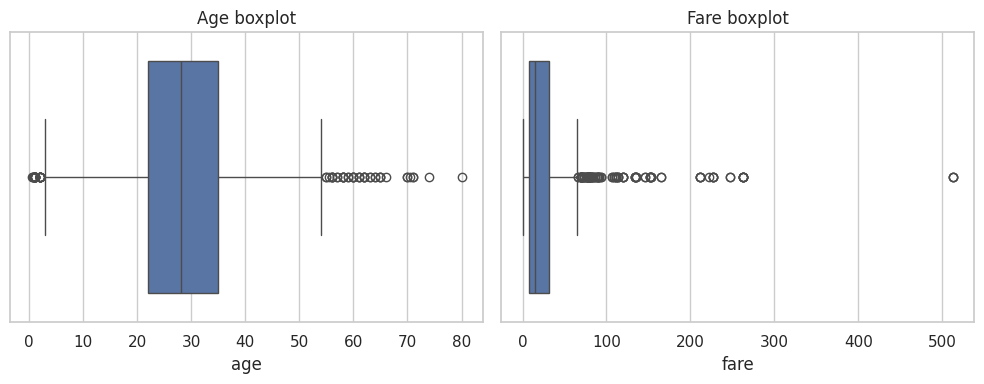

In [11]:
# === Cell 11: Outlier detection (IQR & Z-score) and removal ===
# We'll detect outliers based on IQR for 'fare' and 'age'. We'll create columns marking outliers.
def iqr_outlier_mask(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k*iqr
    upper = q3 + k*iqr
    return (series < lower) | (series > upper)

data_encoded['age_outlier'] = iqr_outlier_mask(data_encoded['age'])
data_encoded['fare_outlier'] = iqr_outlier_mask(data_encoded['fare'])

print("Outlier counts (IQR method):")
display(data_encoded[['age_outlier','fare_outlier']].sum())

# Visualize with boxplots
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.boxplot(x=data_encoded['age'])
plt.title('Age boxplot')

plt.subplot(1,2,2)
sns.boxplot(x=data_encoded['fare'])
plt.title('Fare boxplot')

plt.tight_layout()
plt.show()


In [12]:
# If you prefer to drop outliers (comment/uncomment as required).
# We'll create a cleaned copy where we remove rows that are outliers in FARE OR AGE.
cleaned = data_encoded[~(data_encoded['age_outlier'] | data_encoded['fare_outlier'])].copy()
print("Original rows:", data_encoded.shape[0], "Cleaned rows:", cleaned.shape[0])


Original rows: 891 Cleaned rows: 721


In [13]:
# === Cell 12: Prepare final dataset for modeling or submission ===
# Choose a clean feature set (drop helper columns like mm/std copies and outlier flags)
drop_cols = ['age_std','age_mm','fare_std','fare_mm','age_outlier','fare_outlier']
final = cleaned.drop(columns=drop_cols)

# If you intend to scale numeric features for model, apply StandardScaler in a pipeline during modeling.
print("Final dataset shape:", final.shape)
display(final.head())


Final dataset shape: (721, 26)


,survived,pclass,age,sibsp,parch,fare,adult_male,sex__female,sex__male,embarked__C,...,deck__E,deck__F,deck__G,deck__Missing,who__child,who__man,who__woman,class__First,class__Second,class__Third
0,0,3,22.0,1,0,7.2500,True,False,True,False,...,False,False,False,True,False,True,False,False,False,True
2,1,3,26.0,0,0,7.9250,False,True,False,False,...,False,False,False,True,False,False,True,False,False,True
3,1,1,35.0,1,0,53.1000,False,True,False,False,...,False,False,False,False,False,False,True,True,False,False
4,0,3,35.0,0,0,8.0500,True,False,True,False,...,False,False,False,True,False,True,False,False,False,True
5,0,3,28.0,0,0,8.4583,True,False,True,False,...,False,False,False,True,False,True,False,False,False,True


In [14]:
# === Cell 13: Save cleaned dataset (CSV) ===
# Save to /content so you can download in Colab
cleaned.to_csv('/content/titanic_cleaned.csv', index=False)
final.to_csv('/content/titanic_final_for_model.csv', index=False)
print("Saved files:\n - /content/titanic_cleaned.csv\n - /content/titanic_final_for_model.csv")


Saved files:
 - /content/titanic_cleaned.csv
 - /content/titanic_final_for_model.csv


Survival rate (original): 0.3838383838383838
Survival rate (cleaned): 0.33703190013869627


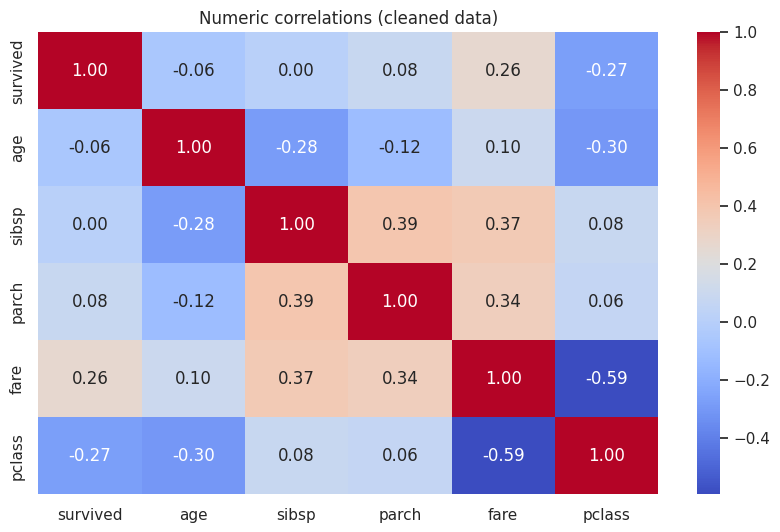

In [15]:
# === Cell 14: Quick sanity checks & correlations ===
print("Survival rate (original):", df['survived'].mean())
print("Survival rate (cleaned):", cleaned['survived'].mean())

# Correlation heatmap (just numeric columns)
plt.figure(figsize=(10,6))
num_cols = ['survived','age','sibsp','parch','fare','pclass']
sns.heatmap(cleaned[num_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Numeric correlations (cleaned data)")
plt.show()


In [16]:
# === Cell 15: Example: small baseline model (optional) ===
# This section is optional but useful to see preprocessing effect.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Prepare X,y (drop 'survived' and non-feature columns)
y = final['survived']
X = final.drop(columns=['survived'])

# For modeling we should scale numeric features - do it here quickly
num_features = ['age','sibsp','parch','fare','pclass']
X_scaled = X.copy()
X_scaled[num_features] = StandardScaler().fit_transform(X_scaled[num_features])

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print("Baseline Logistic Regression Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred, digits=3))


Baseline Logistic Regression Accuracy: 0.7931034482758621
              precision    recall  f1-score   support

           0      0.824     0.875     0.848        96
           1      0.721     0.633     0.674        49

    accuracy                          0.793       145
   macro avg      0.772     0.754     0.761       145
weighted avg      0.789     0.793     0.789       145

